In [1]:
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math

sys.path.append("../../")

from helpers.split import tag_label_feature_split, label_strings
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split

# sources:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

df = pd.read_pickle("../../datasets/baseline_dataset.pickle")
_, one_hot_labels, Xraw = tag_label_feature_split(df)
yStrings=label_strings(one_hot_labels)

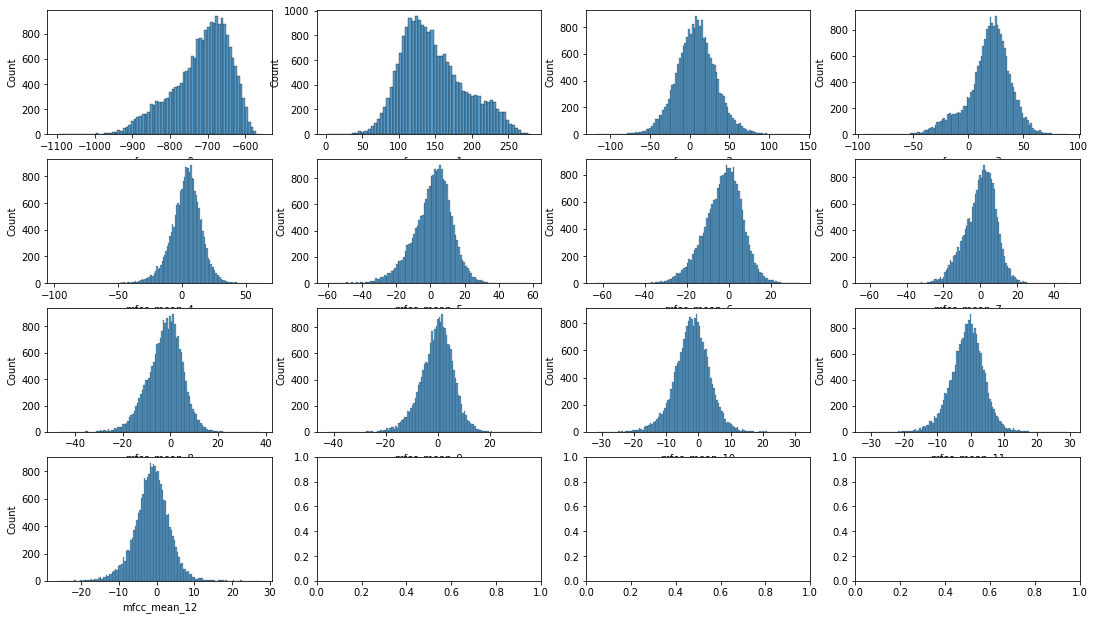

In [2]:
fig, axes = plt.subplots(4, 4,facecolor='white')
fig.set_size_inches(18.5, 10.5)

for i in range(13):
    row = math.floor(i/4)
    col = i %4

    sns.histplot(data=Xraw, x=f"mfcc_mean_{i}",ax=axes[row,col])

# Standardization of a dataset is a common requirement for many machine learning
# estimators: they might behave badly if the individual features do not more or
# less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

# Observing our baseline data below, it appears to be a good candidate for standardization

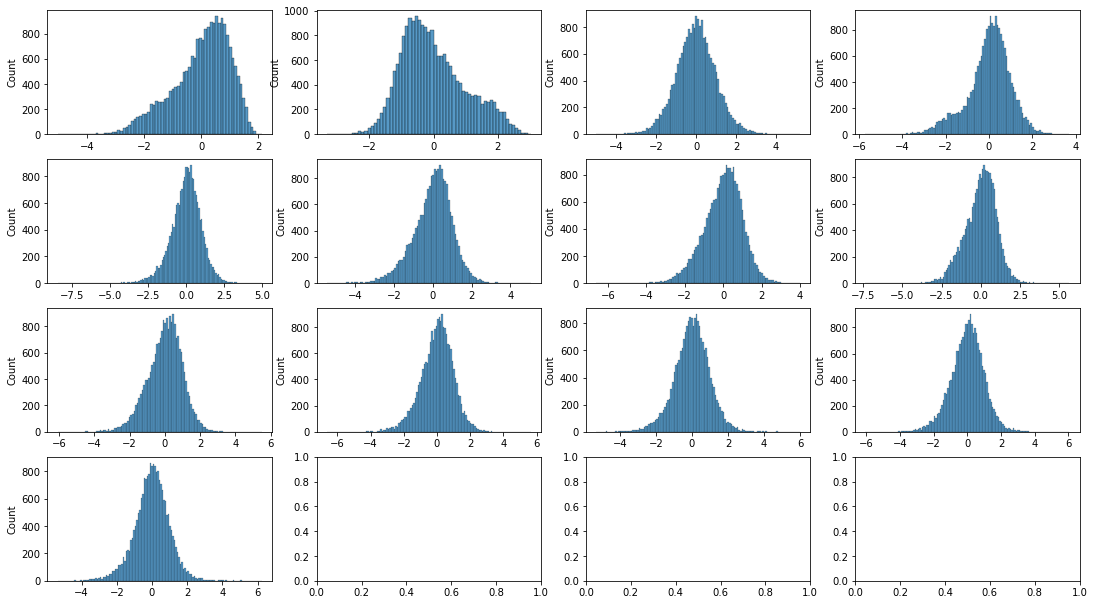

In [3]:
X = StandardScaler().fit_transform(Xraw)

fig, axes = plt.subplots(4, 4,facecolor='white')
fig.set_size_inches(18.5, 10.5)

for i in range(13):
    row = math.floor(i/4)
    col = i %4

    sns.histplot(data=X[:,i], ax=axes[row,col])

# Baseline var distributions after scaling

In [4]:

# convert to 2D numpy array for X, 1D numpy array for Y
y = yStrings.to_numpy().flatten()

# convert y label of strings to class indexes
y_label_names = list(np.unique(y))
y_label_names.sort()
label_name_to_int = lambda s: 1
y = np.vectorize(lambda s: y_label_names.index(s))(y)

# there may be a sklearn help fn to do this easier?

In [5]:
# split data into test and train sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)


In [9]:
# calculate weights for each label
class_weight_arr = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y_train_all)
class_weight = dict(zip(np.unique(y), class_weight_arr))

In [ ]:

# K-fold Cross Validation model evaluation
number_folds = 5
learning_rate = 0.01
batch_size = 10
epochs = 10
hidden_layers = 0 # should be 0 for baseline model
hidden_size = 10
fold_accuracy = []
fold_loss = []
active_fold_number = 1

# create the generator that will return the next fold on each call
skf = StratifiedKFold(n_splits=number_folds, random_state=None, shuffle=False)

for train_idx, test_idx in skf.split(X_train_all, y_train_all):

  model = tf.keras.Sequential()
  for _ in range(hidden_layers):
    model.add(tf.keras.layers.Dense(
        units=hidden_size,
        activation='tanh'
    ))
  model.add(tf.keras.layers.Dense(
      units=len(np.unique(y)),
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
  model.compile(
      loss='sparse_categorical_crossentropy',     
      optimizer=optimizer, 
      metrics=['accuracy']
  )

  print('------------------------------------------------------------------------')
  print(f'Training Fold {active_fold_number} ...')

  # Fit data to model
  history = model.fit(
      X_train_all[train_idx],
      y_train_all[train_idx],
      batch_size=batch_size,
      epochs=epochs,
      class_weight=class_weight,
      verbose=1
  )
    
# Generate generalization metrics
  scores = model.evaluate(
      X_train_all[test_idx],
      y_train_all[test_idx],
      verbose=0
  )
  print(f'Score for fold {active_fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  fold_accuracy.append(scores[1] * 100)
  fold_loss.append(scores[0])

  # Increase fold number
  active_fold_number = active_fold_number + 1


print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(fold_accuracy)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {fold_loss[i]} - Accuracy: {fold_accuracy[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(fold_accuracy)} (+- {np.std(fold_accuracy)})')
print(f'> Loss: {np.mean(fold_loss)}')
print('------------------------------------------------------------------------')


    

  

------------------------------------------------------------------------
Training Fold 1 ...
Epoch 1/10
1367/1367 [==============================] - 1s 636us/step - loss: 2.0775 - accuracy: 0.2742
Epoch 2/10
1367/1367 [==============================] - 1s 686us/step - loss: 1.8645 - accuracy: 0.3326
Epoch 3/10
1367/1367 [==============================] - 1s 610us/step - loss: 1.8104 - accuracy: 0.3509
Epoch 4/10
1367/1367 [==============================] - 1s 620us/step - loss: 1.7865 - accuracy: 0.3586
Epoch 5/10
1367/1367 [==============================] - 1s 609us/step - loss: 1.7733 - accuracy: 0.3665
Epoch 6/10
1367/1367 [==============================] - 1s 604us/step - loss: 1.7672 - accuracy: 0.3702
Epoch 7/10
1367/1367 [==============================] - 1s 604us/step - loss: 1.7620 - accuracy: 0.3758
Epoch 8/10
1367/1367 [==============================] - 1s 613us/step - loss: 1.7579 - accuracy: 0.3740
Epoch 9/10
1367/1367 [==============================] - 1s 612us/step - los